# Задачи, цели работы


## Цель работы


Цель этой лабораторной работы - изучить и применить готовые библиотеки для оптимизации на Python, в частности, PyTorch и различные методы оптимизации из SciPy. Также, требуется сравнить эффективность работы этих методов с нашими реализациями из прошлых работ.

## Задачи для достижения указанной цели

1. Изучить использование вариантов SGD (torch.optim) из PyTorch. Исследовать их эффективность и сравнить с собственными реализациями из предыдущих работ.
2. Изучить использование готовых методов оптимизации из SciPy (scipy.optimize.minimize, scipy.optimize.least_squares). Исследовать их эффективность и сравнить с собственными реализациями из предыдущих работ.
3. Реализовать использование PyTorch для вычисления градиента и сравнить его с другими подходами.
4. Исследовать, как задание границ изменения параметров влияет на работу методов из SciPy.
5. Исследовать использование линейных и нелинейных ограничений при использовании scipy.optimize.minimize из SciPy. Рассмотреть случаи, когда минимум находится на границе заданной области и когда он расположен внутри.
6. Подготовить отчет, содержащий описание реализованных алгоритмов, реализацию, необходимые тесты и таблицы. Отчет должен также включать анализ результатов, преимуществ и ограничений методов.

# Ход работы

## Подготовка среды, определение полезных функций

### В предыдущих сериях:

In [17]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import profiler
import descent
import regression
import visualization
import dataset

In [18]:
plt.rcParams["figure.figsize"] = (10, 10)
np.set_printoptions(precision=2, suppress=False)

### Dataset

В качестве задачи Least Squares мы будем использовать модель нелинейной регрессии из прошлой работы на базе датасета изменения погоды от Яндекса:

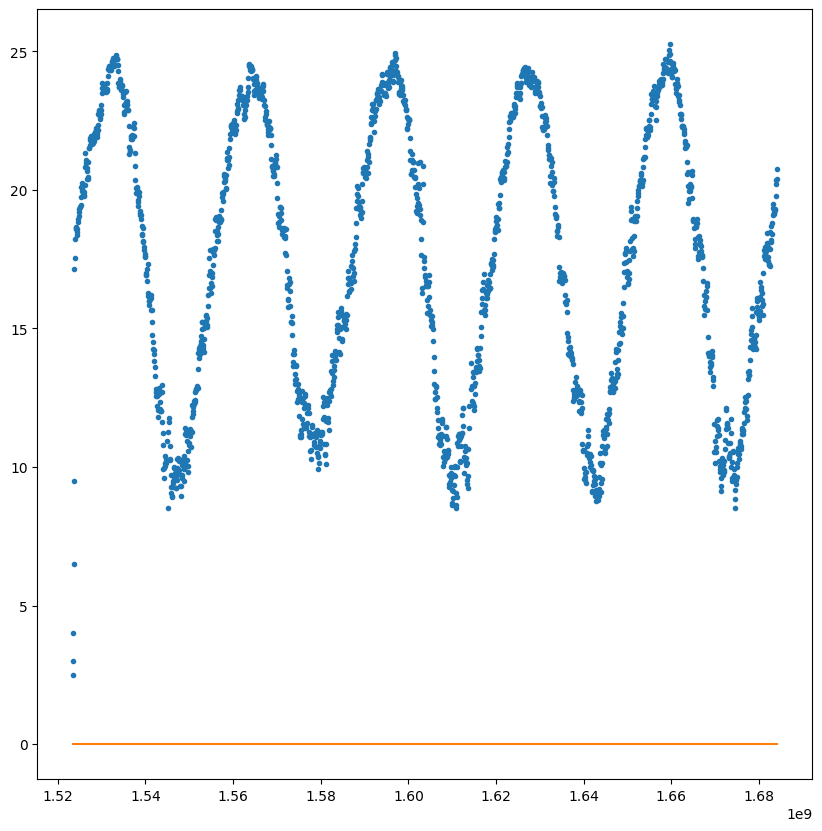

In [19]:
data = dataset.get_data()
data_weather = dataset.get_data_weather()
visualization.visualize_regression([0.0], *data_weather)

Как видим, данные вполне периодичны. Попробуем их описать синусом:

Определим модель как
$$M(x, W) = W_1 + W_2 \cdot x + W_3 \cdot x^2 + W_4 \cdot x^3 + W_5 \cdot \sin (x \cdot W_6 + W_7)$$
Тогда Loss-функция будет выглядеть как
$$
f(W) = \sum_{i\in{DATA_x}} (DATA_{yi} - M(i))^2
$$

In [20]:
f_weather, f_weather_chunk = dataset.get_nonlinear_loss_func(*data_weather)

В качестве квадратичной задачи для градиентного спуска, будем использовать Loss-функцию линейной регрессии из работы №2. Она построена на базе датасета успеваемости студентов в зависимости от количества часов подготовки:

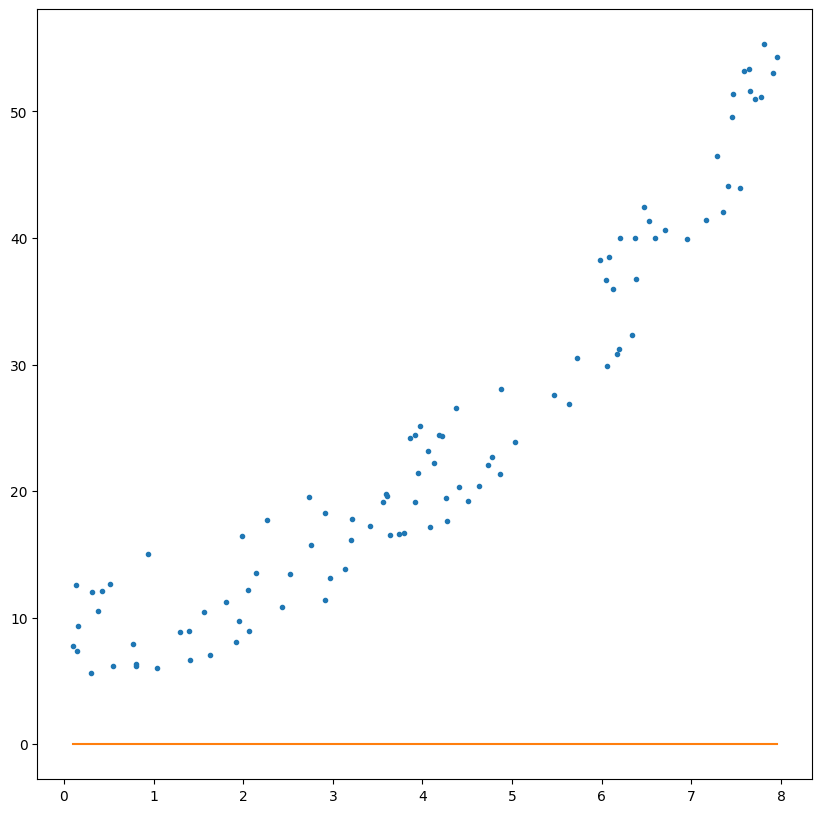

In [21]:
f_stud, f_stud_chunk = dataset.get_linear_loss_func(*data)
visualization.visualize_regression([0.0], *data)

### Rosenbrock function

Она пригодится для сравнения работы различных алгоритмов оптимизации

Определим её следующим образом:
$$
f(x, y) = (1 - x)^2 + 100(y - x^2)^2
$$
Это нелинейная функция, будем использовать её минимизировать для демонстрации работы некоторых методов в будущем.

## Задание 1. Исследование реализации SGD из Pytorch

В прошлых работах были реализованы методы:
- Sgd
- Sgd with momentum
- Rmsprop
- Adagrad
- Adam

In [22]:
from descent import (
    minibatch_descent,
    nesterov_minibatch_descent,
    rmsprop_minibatch_descent,
    adagrad_minibatch_descent,
    adam_minibatch_descent,
)

### Функция Розенброка

#### Наша реализация

Глобальный минимум: [1.0, 1.0]


,Метод,Всего точек,Минимум в,Значение в точке минимума
0,Adam,1001,"[1.3210390701332115, 1.7270224562006466]",0.135906
1,SGD,1001,"[0.0012623699298305868, -3.4538746885766614]",1193.923614
2,Nesterov,1001,"[0.06923394154883589, 0.003574003388420655]",0.866474
3,RMSProp,1001,"[0.8466360752132726, 0.7189900476679795]",0.024003
4,Adagrad,1001,"[-1.8202067257913244, 3.3022796503860334]",7.965388


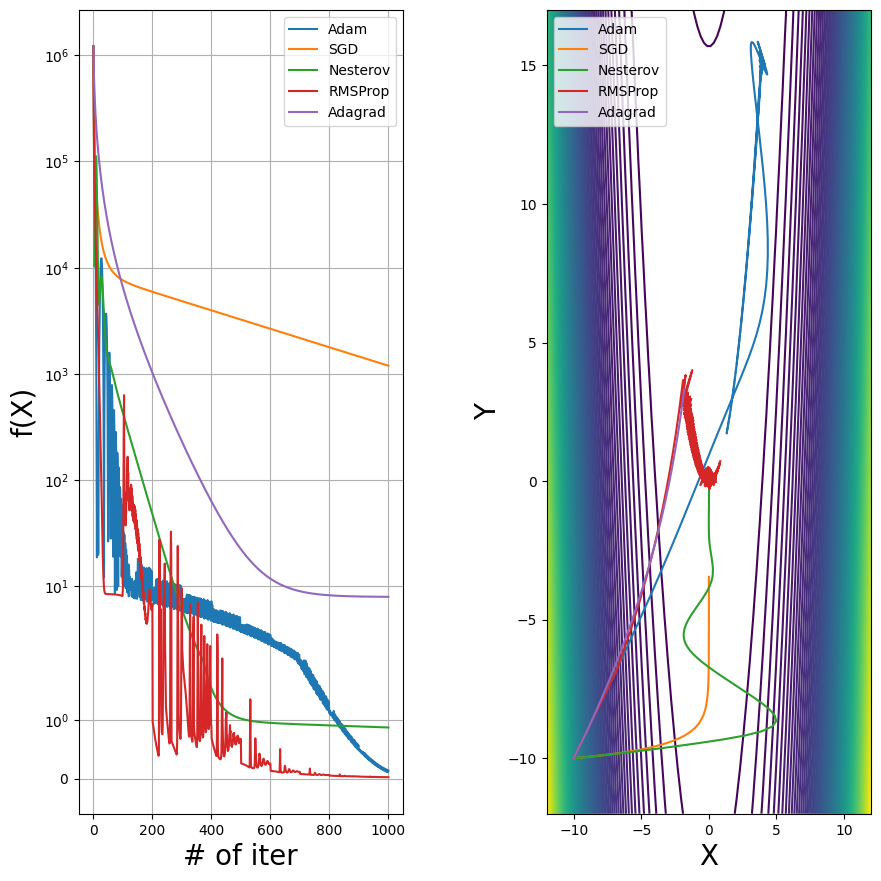

In [23]:
from funcs import squared, f_rosenbrock, f_rosenbrock_chunk

print("Глобальный минимум: [1.0, 1.0]")
visualization.visualize_multiple_descent_2args(
    {
        "Adam": adam_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            decay=descent.step_decay(1.0, 0.8, 100),
            n_epochs=1000,
            tol=0.01,
            betta1=0.9,
            betta2=0.9,
        ),
        "SGD": minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(0.00001),
            n_epochs=1000,
            tol=0.01,
        ),
        "Nesterov": nesterov_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(0.0001),
            n_epochs=1000,
            tol=0.01,
            alpha=0.9,
        ),
        "RMSProp": rmsprop_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.step_decay(1.0, 0.5, 100),
            n_epochs=1000,
            tol=0.01,
            alpha=0.9,
        ),
        "Adagrad": adagrad_minibatch_descent(
            f=squared(f_rosenbrock_chunk()),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(1.0),
            n_epochs=1000,
            tol=0.01,
        ),
    },
    f_rosenbrock,
    print_points=True,
)

#### Pytorch

Подготовим аналогичные методы в реализации PyTorch

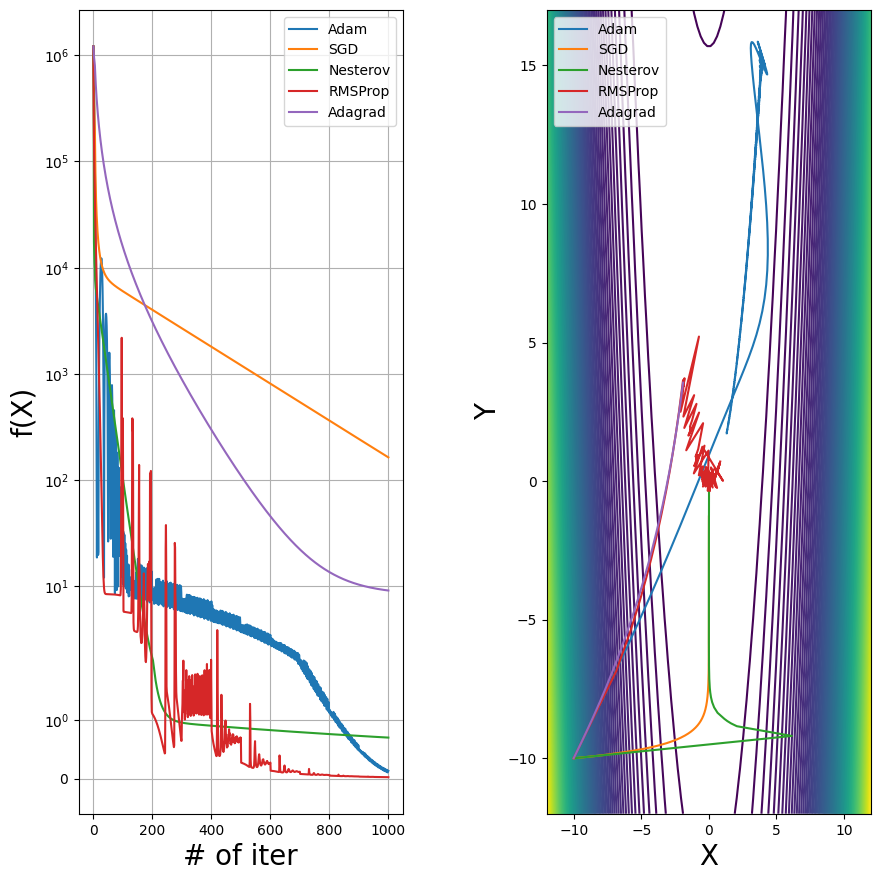

In [24]:
import torch
import descent

visualization.visualize_multiple_descent_2args(
    {
        "Adam": descent.torch_descent(
            torch.optim.Adam(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
                betas=(0.9, 0.9),
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.StepLR,
            100,  # Step size
            0.8,  # Gamma
        ),
        "SGD": descent.torch_descent(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.00001,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Nesterov": descent.torch_descent(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.0001,
                momentum=0.1,
                nesterov=True,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "RMSProp": descent.torch_descent(
            torch.optim.RMSprop(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
                alpha=0.9,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.StepLR,
            100,  # Step size
            0.5,  # Gamma
        ),
        "Adagrad": descent.torch_descent(
            torch.optim.Adagrad(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
            ),
            f_rosenbrock,
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
    },
    f_rosenbrock,
)

Ввиду обусловленности представленной функции, обычный стохастический спуск так и не удалось адекватно стабилизировать, он начал сходиться только при чрезвычайно маленьком Learning Rate (1e-5). Каждое его улучшение помогает улучшить и ускорить сходимость, что отлично видно на графиках, учитывая подобранный Learning Rate для каждого из методов.

### Линейная регрессия

#### Наша реализация

,Метод,Всего точек,Минимум в,Значение в точке минимума
0,Adam,50001,"[1.6957174008537985, 5.597533888050046]",22.845404
1,Nesterov,50001,"[1.1180379343454432, 5.709306826607482]",22.791871
2,RMSProp,50001,"[1.2287422043117449, 5.688703875860892]",22.789053
3,Adagrad,50001,"[1.2244127838207508, 5.6941920191613935]",22.789713
4,SGD,50001,"[1.2011591908662382, 5.692202516756247]",22.789172


Elapsed:  57.273552894592285 sec.


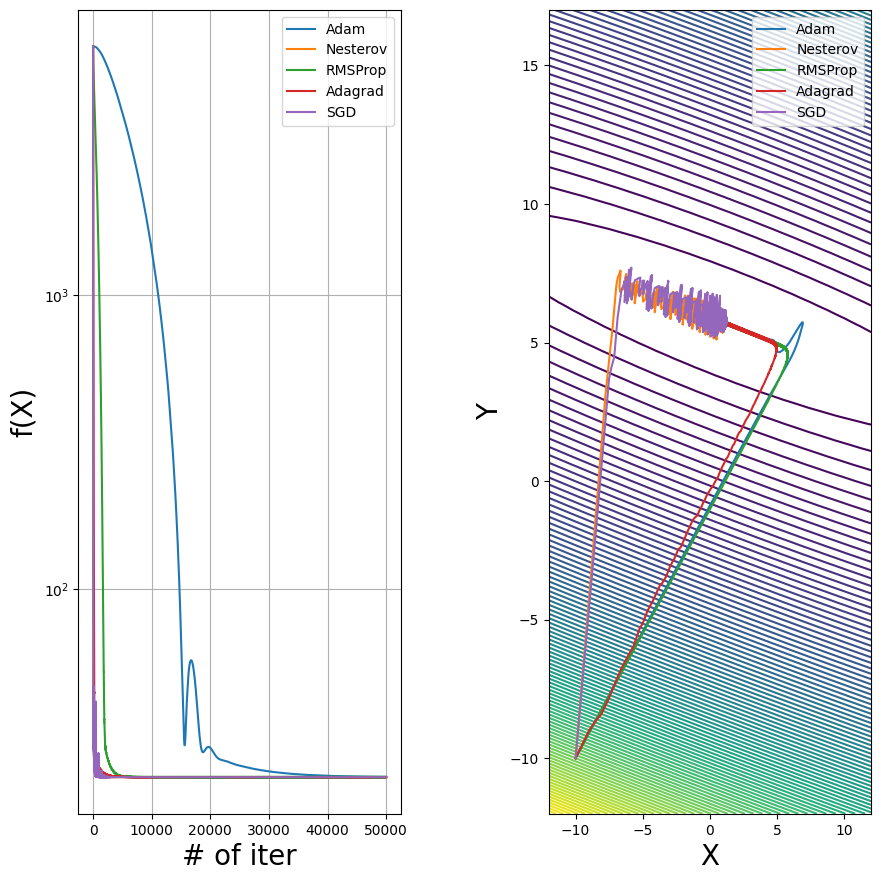

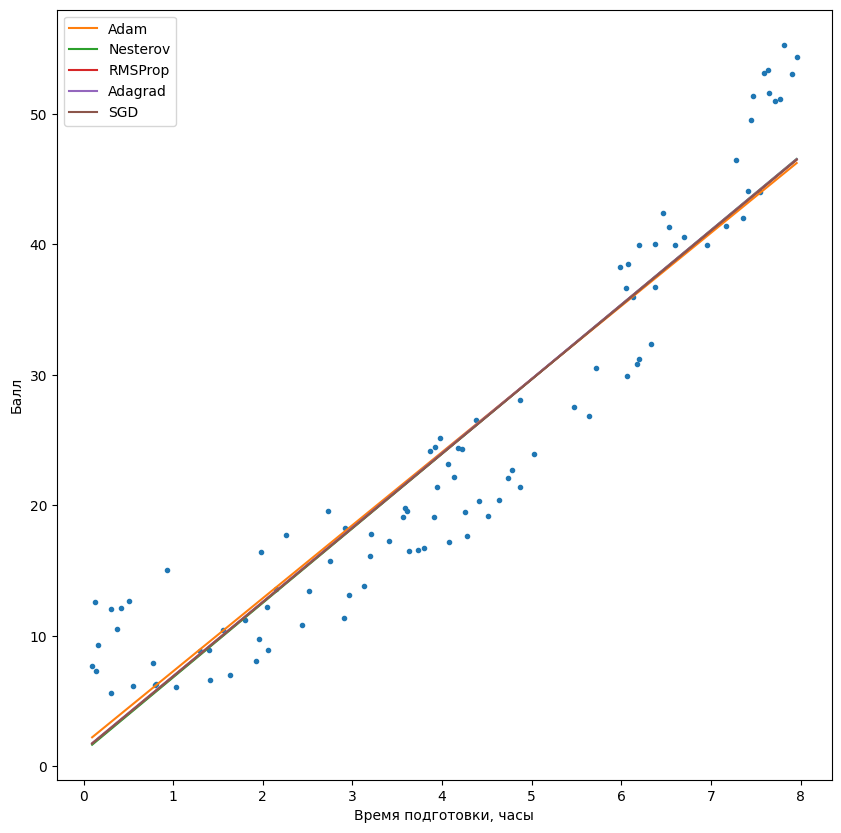

In [26]:
from funcs import squared
import time

calc_start = time.time()
visualization.linear_multiple_demo_2args(
    {
        "Adam": adam_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            decay=descent.constant_lr_decay(1e-3),
            n_epochs=1000,
            tol=1e-7,
            betta1=0.9,
            betta2=0.999,
            batch_size=2,
        ),
        "Nesterov": nesterov_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.step_decay(0.01, 0.5, 10),
            n_epochs=1000,
            tol=1e-7,
            alpha=0.35,
            batch_size=2,
        ),
        "RMSProp": rmsprop_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(0.01),
            n_epochs=1000,
            tol=1e-7,
            alpha=0.99,
            batch_size=2,
        ),
        "Adagrad": adagrad_minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.constant_lr_decay(1.0),
            n_epochs=1000,
            tol=1e-7,
            batch_size=2,
        ),
        "SGD": minibatch_descent(
            f=squared(f_stud_chunk),
            df=descent.numeric_gradient,
            x0=np.array([-10.0, -10.0]),
            lr=descent.step_decay(0.01, 0.5, 10),
            n_epochs=1000,
            tol=1e-7,
            batch_size=2,
        ),
    },
    f_stud,
    *data
)
print("Elapsed: ", time.time() - calc_start, "sec.")

#### Pytorch

В PyTorch существуют абстракции для построения лосс-функций из датасетов. Так, мы можем воспользоваться `torch.util.data.DataSet` для представления нашего датасета "про студентов" в формате PyTorch.

Далее, мы можем воспользоваться `torch.util.data.DataLoader` для разбиения нашего датасета на батчи, из которых, в свою очередь, мы будем формировать Loss-функцию на каждой итерации в процессе оптимизации.

Так, мы сделаем наш `torch.optim.SGD` по-настоящему SGD. Как ни странно, в самой реализации от PyTorch у SGD нет ничего стохастического и разбиение функции на батчи - это целиком наша задача.

In [27]:
from funcs import torch_loss
from torch.utils.data import DataLoader
import dataset

y = torch.tensor(data[1], dtype=torch.float)
x = torch.tensor(data[0], dtype=torch.float)
data_set = dataset.TorchDataset(x, y)

torch_loss(x, y)(
    torch.tensor([3.247829835435748, 5.313336982957038])
)  # Eventually, data_set will be consumed by DataLoader
# that will be able to split it into batches in the same "x, y" format that can be consumed by "torch_loss" loss-function factory

AttributeError: module 'dataset' has no attribute 'TorchDataset'

In [ ]:
calc_start = time.time()
visualization.linear_multiple_demo_2args(
    {
        "Adam": descent.torch_descent_stochastic(
            torch.optim.Adam(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1e-3,
                betas=(0.9, 0.999),
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Nesterov": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.01,
                nesterov=True,
                momentum=1 - 0.35,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.StepLR,
            10,  # Step size
            0.5,  # Gamma
        ),
        "RMSProp": descent.torch_descent_stochastic(
            torch.optim.RMSprop(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.01,
                alpha=0.99,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Adagrad": descent.torch_descent_stochastic(
            torch.optim.Adagrad(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=1.0,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "SGD": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True)],
                lr=0.01,
            ),
            torch_loss,
            DataLoader(dataset=data_set, batch_size=2),
            1000,
            torch.optim.lr_scheduler.StepLR,
            10,  # Step size
            0.5,  # Gamma
        ),
    },
    f_stud,
    *data
)
print("Elapsed: ", time.time() - calc_start, "sec.")

Итак, судя по графикам, результаты работы алгоритмов чрезвычайно похожи. Однако, реализация PyTorch работала всего 43.563 секунды против 73.169 у нашей реализации.

Ускорение в 1.68 раза, более точное вычисление производных благодаря дуальным числам - это ещё не всё, что может дать нам PyTorch. Покажем его истинную силу:

### CUDA

Да-да, настоящая сила PyTorch сокрыта в возможности отправить вычисления прямо на нашу видеокарту. Добиться этого нетрудно, достаточно
правильно скомпилировать библиотеку, установить нужные CUDA рантаймы, иметь поддерживаемую карту, а так же проинициализировать всё правильно:

In [ ]:
import torch

torch.cuda.is_available()

Видим, что `cuda.is_available() == True`, а значит, мы можем двигаться дальше. Осталось просто добавить нашим тензорам параметр `device=cuda` и "дело в шляпе":

In [ ]:
cuda = torch.device("cuda:0")
torch.cuda.get_device_name(cuda)

In [ ]:
x_cuda = x.to(cuda)
y_cuda = y.to(cuda)
data_set_cuda = dataset.TorchDataset(x_cuda, y_cuda)

torch_loss(x_cuda, y_cuda)(
    torch.tensor([3.247829835435748, 5.313336982957038], device=cuda)
)

In [ ]:
import time

calc_start = time.time()
visualization.linear_multiple_demo_2args(
    {
        "Adam": descent.torch_descent_stochastic(
            torch.optim.Adam(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=5e-2,
                betas=(0.9, 0.999),
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Nesterov": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=0.01,
                nesterov=True,
                momentum=1 - 0.35,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.StepLR,
            500,  # Step size
            0.5,  # Gamma
        ),
        "RMSProp": descent.torch_descent_stochastic(
            torch.optim.RMSprop(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=0.01,
                alpha=0.99,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "Adagrad": descent.torch_descent_stochastic(
            torch.optim.Adagrad(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=1.0,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.ConstantLR,
        ),
        "SGD": descent.torch_descent_stochastic(
            torch.optim.SGD(
                [torch.tensor([-10.0, -10.0], requires_grad=True, device=cuda)],
                lr=0.01,
            ),
            torch_loss,
            DataLoader(dataset=data_set_cuda, batch_size=100),
            10000,
            torch.optim.lr_scheduler.StepLR,
            500,  # Step size
            0.5,  # Gamma
        ),
    },
    f_stud,
    *data
)
print("Elapsed: ", time.time() - calc_start, "sec.")

Итак, на предыдущих демонстрациях мы делали epoch*(dataset_size/batch_size)=1000*(100/2)=50000 итераций стохастического спуска.

Теперь мы смогли перенести вычисления на GPU, благодаря чему мы можем значительно снизить стоимость увеличения batch_size.
То есть теперь мы можем делать не стохастический спуск одновременно по всему датасету, что позволяет значительно повысить точность спуска и, следовательно, увеличить learing_rate и уменьшить число epoch
А так же, мы можем бесплатно увеличивать размер датасета, что не повлияет ни на скорость спуска, так как итерации вычисления градиента по всему батчу распараллелены на CUDA ядрах.
Это может продолжаться пока у нас хватает вычислителей и видеопамяти для таких манипуляций. То есть теперь batch_size выгодно выставить именно такого размера, какой видеокарта может эффективно распараллелить (в нашем случае датасет имеет размер всего 100, а значит batch_size будет равен размеру датасета).


Увеличим epoch в 50 раз, получим 50000*(100/100)=50000 итераций НЕСТОХАСТИЧЕСКОГО спуска. Точность гораздо выше, а время вычислений всего 5 минут (в 5 раз выше однопоточных вычислений на процессоре, при том, что мы увеличили стоимость каждого шага в 50 раз за счёт увеличения batch_size).

Теперь воспользуемся преимуществом в точности спуска и уменьшим число epoch в 5 раз (теперь имеем 10000*(100/100)=10000 итераций). Все алгоритмы сошлись идеально в одной точке минимума точнее, чем за 50000 итераций на процессоре (так как спуск более не стохастический всё же), но при этом время вычисления вообще не изменилось: имеем всё те же 60 секунд, что и раньше.

### Вывод

В ходе выполнения задания было проведено сравнение собственной реализации методов оптимизации на Python и реализации этих же методов в библиотеке PyTorch. Были рассмотрены следующие методы: SGD, Nesterov, RMSprop, Adagrad и Adam.

Согласно полученным результатам, обе реализации показывают схожие результаты в плане сходимости алгоритмов. Однако, реализация PyTorch показала значительное преимущество в скорости работы - она была быстрее на 68%, что является важным фактором при работе с большими объемами данных.

Более того, PyTorch предоставляет возможность использования вычислительных ресурсов графического процессора (GPU), что позволяет еще больше ускорить процесс оптимизации. Это особенно актуально при работе с большими объемами данных и когда возможно использование больших размеров батчей.

Так, при использовании GPU, время вычислений сократилось до 5 минут при увеличении количества эпох в 50 раз, что в 5 раз быстрее, чем однопоточные вычисления на процессоре. При этом, точность спуска значительно возросла благодаря использованию нестохастического спуска.

Вывод: использование готовых реализаций методов оптимизации из библиотеки PyTorch позволяет значительно ускорить процесс оптимизации, увеличить его точность и эффективно использовать ресурсы графического процессора. Это делает PyTorch предпочтительным выбором для работы с большими объемами данных и сложными моделями.


## Задание 2. Исследование методов оптимизации SciPy


### Сравнение с прошлой работой

In [ ]:
import descent
import bfgs

reload(descent)
reload(visualization)

visualization.visualize_multiple_descent_2args_wh_time(
    {
        "bfgs": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="bfgs",
            tol=1e-6,
            jac="2-point",
        ),
        "dogleg": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="dogleg",
            tol=1e-6,
            jac=descent.get_jac(f_rosenbrock),
            hess=descent.get_hess(f_rosenbrock),
        ),
        "newton": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="newton-cg",
            tol=1e-6,
            jac=descent.get_jac(f_rosenbrock),
        ),
        "dogleg ours": lambda: descent.powell_dog_leg(
            x0=np.array([-10.0, -10.0]),
            rsl=f_rosenbrock_chunk(),
            grad=descent.numeric_gradient,
        ),
        "bfgs ours": lambda: bfgs.bfgs(
            f_rosenbrock,
            descent.numeric_gradient,
            x_0=np.array((-1.0, -1.0)),
            epochs=1000,
        ),
        "l-bfgs ours": lambda: bfgs.l_bfgs(
            f_rosenbrock,
            descent.numeric_gradient,
            x_0=np.array((-10.0, -10.0)),
            epochs=1000,
        ),
    },
    f_rosenbrock,
)

Все методы, как встроенные, так и самописные, успешно сходятся к минимуму функции Розенброка.

* Время работы встроенных функций оптимизации в общем больше, чем время работы самописных реализаций. Это может объясняться тем, что встроенные функции содержат дополнительные проверки, что приводит к дополнительному времени выполнения.

* Все самописные функции показали более эффективное использование памяти по сравнению с встроенными функциями. Это опять-таки может объясняться меньшим количеством дополнительных проверок и функций в самописных реализациях.

* Встроенные функции требуют больше точек для сходимости.

Таким образом, эти результаты показывают, что, хотя самописные функции оптимизации могут быть более эффективными с точки зрения времени выполнения и использования памяти, встроенные функции оптимизации могут быть более универсальными, что делает их более подходящими для общего использования. Однако, в определенных ситуациях и с учетом определенных требований, самописные функции могут оказаться предпочтительнее.

In [ ]:
import descent
import bfgs

reload(descent)
reload(bfgs)
reload(visualization)

f, f_chunk = dataset.get_linear_loss_func(*data)
x0 = np.array([-30.0, -30.0])
visualization.linear_multiple_demo_2args_wh_time(
    {
        "bfgs": lambda: descent.scipy_descent(
            f, x0, method="bfgs", tol=1e-6, jac="2-point"
        ),
        "dogleg": lambda: descent.scipy_descent(
            f,
            x0,
            method="dogleg",
            tol=1e-6,
            jac=descent.get_jac(f),
            hess=descent.get_hess(f),
        ),
        "dogleg ours": lambda: descent.powell_dog_leg(
            x0=x0, rsl=f_chunk, grad=descent.numeric_gradient
        ),
        "bfgs ours": lambda: bfgs.bfgs(
            f, descent.numeric_gradient, x_0=x0, epochs=10
        ),        
        "gauss_newton ours": lambda: descent.gauss_newton_descent(
            x0=x0, rsl=f_chunk, grad=descent.numeric_gradient
        ),

    },
    f,
    *data
)

### Вычисление градиента с помощью PyTorch, сравнение

1. bfgs vs bfgs ours: Встроенная реализация метода BFGS сходится, используя большее количество точек, чем собственная реализация.
2. dogleg vs dogleg ours: Встроенная реализация метода Dogleg сходится с использованием меньшего количества точек по сравнению с собственной реализацией, но время работы встроенной реализации значительно выше. Это может быть связано с более сложной и универсальной реализацией встроенного метода. С точки зрения использования памяти, наша реализация оказывается более эффективной.

Таким образом, собственные реализации методов показывают хорошую производительность, но имеют некоторые недостатки по сравнению с встроенными функциями из библиотеки scipy. Это связано в первую очередь с тем, что scipy оптимизирован для работы с большим спектром задач, а наши реализации были ориентированы на конкретные случаи использования. Поэтому стоит учесть, что в более общих сценариях использования встроенные функции могут показывать более высокую производительность и надежность.

In [ ]:
reload(visualization)
visualization_area=((-25, 10),(-30, 150))
visualization.visualize_multiple_descent_2args_wh_time(
    {
        "BFGS": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="bfgs",
            tol=1e-6,
            jac="2-point",
        ),
        "Newton": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="newton-cg",
            tol=1e-6,
            jac=descent.get_jac(f_rosenbrock),
        ),
        "CG": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="CG",
            tol=1e-6,
            jac="2-point",
        ),
        "Nelder-Mead": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            method="Nelder-Mead",
            tol=1e-6,
        ),
    },
    f_rosenbrock,
    visualization_area=visualization_area,
)
visualization.visualize_multiple_descent_2args_wh_time(
    {
        "BFGS torch": lambda: descent.scipy_descent(
            f_rosenbrock_torch,
            np.array([-10.0, -10.0]),
            method="bfgs",
            tol=1e-6,
            jac=True,
        ),
        "Newton torch": lambda: descent.scipy_descent(
            f_rosenbrock_torch,
            np.array([-10.0, -10.0]),
            method="newton-cg",
            tol=1e-6,
            jac=True,
        ),
        "CG torch": lambda: descent.scipy_descent(
            f_rosenbrock_torch,
            np.array([-10.0, -10.0]),
            method="CG",
            tol=1e-6,
            jac=True,
        ),
        "Nelder-Mead torch": lambda: descent.scipy_descent(
            f_rosenbrock_torch,
            np.array([-10.0, -10.0]),
            method="Nelder-Mead",
            tol=1e-6,
            jac=True,
        ),
    },
    f_rosenbrock,
    visualization_area=visualization_area,
)


1. BFGS: Оба метода сходятся к очень близким минимумам, но реализация с использованием PyTorch обеспечивает более точное значение минимума, используя меньше итераций.

2. Newton: Оба подхода находят очень близкие минимумы, но Newton torch достигает более точного результата, используя примерно одинаковое количество итераций.

3. CG: Аналогично, оба метода достигают очень близких минимумов, но CG torch обеспечивает более точный минимум, используя примерно одинаковое количество итераций.

4. Nelder-Mead: Результаты для этих методов идентичны, что логично, поскольку метод Nelder-Mead не использует градиенты.

В целом, реализации с автоградиентом работают быстрее, но в при каждом вызове функции нам приходится кастить numpy массив в pytorch тензор, из-за чего время работы увеличивается.

### Изменение параметров и границ, сравнение

In [ ]:
import scipy
from funcs import f_rosenbrock

bounds1 = scipy.optimize.Bounds(-2, 2)
bounds2 = scipy.optimize.Bounds(-5, 5)
bounds3 = scipy.optimize.Bounds(-10, 10)
visualization.visualize_multiple_descent_2args_wh_time(
    {
        "bfgs-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            bounds=bounds1,
            method="l-bfgs-b",
            tol=1e-6,
            jac="2-point",
        ),
        "bfgs-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            bounds=bounds2,
            method="l-bfgs-b",
            tol=1e-6,
            jac="2-point",
        ),
        "bfgs-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            np.array([-10.0, -10.0]),
            bounds=bounds2,
            method="l-bfgs-b",
            tol=1e-6,
            jac="2-point",
        ),
    },
    f_rosenbrock,
)

In [ ]:
import scipy
from funcs import f_rosenbrock

bounds3 = scipy.optimize.Bounds(-200, 200)
bounds2 = scipy.optimize.Bounds(-50, 50)
bounds1 = scipy.optimize.Bounds(-10, 10)
x0 = np.array([-10.0, 10.0])
visualization.visualize_multiple_descent_2args_wh_time(
    {
        "TNC-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds1,
            method="tnc",
            tol=1e-6,
            jac="2-point",
        ),
        "TNC-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds2,
            method="tnc",
            tol=1e-6,
            jac="2-point",
        ),
        "TNC-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            bounds=bounds3,
            method="tnc",
            tol=1e-6,
            jac="2-point",
        ),
    },
    f_rosenbrock,
)

In [ ]:
reload(visualization)
x = np.linspace(-10, 10, 100)
y = 3.5 * x + 2.0


def residuals(p):
    return p[0] * x + p[1] - y


bounds1 = Bounds([-5, -5], [5, 5])
bounds2 = Bounds([-10, -10], [10, 10])
bounds3 = Bounds([-20, -20], [20, 20])
x0 = np.array([0.0, 0.0])

visualization.visualize_multiple_descent_2args_wh_time(
    {
        "trust-constr-bounds1": lambda: descent.scipy_least_squares(
            residuals,
            x0.copy(),
            bounds=bounds1,
            ftol=1e-6,
        ),
        "trust-constr-bounds2": lambda: descent.scipy_least_squares(
            residuals,
            x0.copy(),
            bounds=bounds2,
            ftol=1e-6,
        ),
        "trust-constr-bounds3": lambda: descent.scipy_least_squares(
            residuals,
            x0.copy(),
            bounds=bounds3,
            ftol=1e-6,
        ),
    },
    residuals,
    visualize=False,
)


В целом, сужение границ ведет к меньшему числу итераций.

### Вывод

// Вывод

# Бонусное задание

## Задание 1. Исследование использования ограничений SciPy при работе с scipy.optimize.minimize

### scipy.optimize.LinearConstraint

В этом разделе мы учимся использовать инструментарий SciPy для оптимизации функции с ограничениями. Для рассмотрения возьмём уже полюбившуюся нам функцию Розенброка. Она имеет минимум в точке $f(1, 1) = 0$

In [ ]:
from funcs import f_rosenbrock
from visualization import visualize_2arg

visualize_2arg(f_rosenbrock)

Тогда давайте рассмотрим следующие области:

1. $\forall x, y$
2. $-100 < x, y < 100$
3. $0 < x, y < 2$
4. $-10 < x + y < 10$
5. $-100 < 100 x - 100 y < 500$

,Метод,Всего точек,Минимум в,Значение в точке минимума,Время работы,Память
0,lin-cons-1,23,"[0.9997224016172068, 0.9994347974058512]",8.722733e-08,0.006706,114.697917
1,lin-cons-2,23,"[0.9997224437102525, 0.9994348883835761]",8.719022e-08,0.002822,116.723958
2,lin-cons-3,20,"[0.9997754008501852, 0.9995549832008795]",5.215134e-08,0.002359,116.765625
3,lin-cons-4,3,"[0.00961352877473144, -0.009613528774723627]",9.902859e-01,0.000719,116.817708
4,lin-cons-5,2,"[0.9999992474913588, 0.9999992474913606]",5.719311e-11,0.000664,116.875000


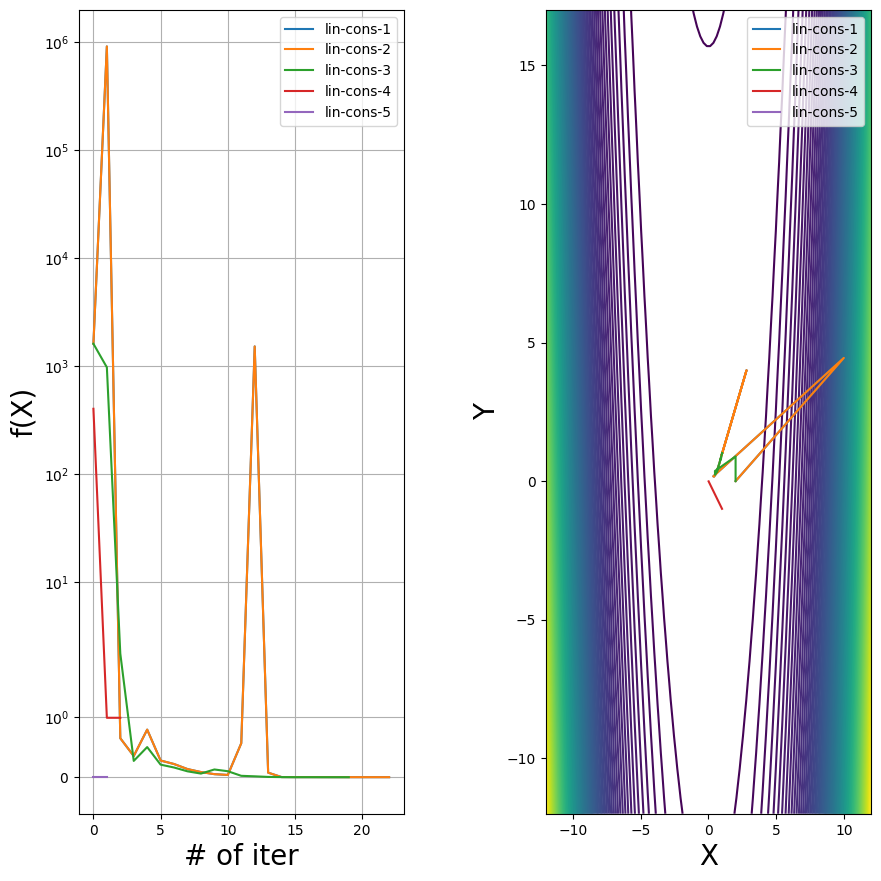

In [31]:
import numpy as np
from scipy.optimize import LinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


lin_cons2 = LinearConstraint([[1, 0], [0, 1,]], [-100, -100], [100, 100])
lin_cons3 = LinearConstraint([[1, 0], [0, 1,]], [-10, -10], [2, 2])
lin_cons4 = LinearConstraint([[1, 1], [0, 0,]], [-10, -10], [0, 0])
lin_cons5 = LinearConstraint([[100, -100], [0, 0,]], [-100, -100], [0, 0])

x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "lin-cons-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            #constraints=lin_cons1,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons3,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-4": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons4,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-5": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons5,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Как можно видеть, при правильном выборе ограничений, можно в разы сократить число необходимых шагов для достижения экстремума. И это даже при достаточно скудном интсрументарии, ведь задавая линейные ограничения мы можем оперировать только линейными комбинациями координат. Также отметим, что в данном примере минимум лежал внутри рассматриваемых областей. Посмотрим, как ведёт себя метод при задаче ограничений, когда минимум находится на границе (или вне)

,Метод,Всего точек,Минимум в,Значение в точке минимума,Время работы,Память
0,lin-cons-2,1,"[0.0, 0.0]",1.000000e+00,0.001866,114.395833
1,lin-cons-3,13,"[10.0, 99.99999927369475]",8.100000e+01,0.001616,115.359375
2,lin-cons-4,15,"[1.0000650570018368, 1.0001294358989337]",4.278972e-09,0.001748,115.536458
3,lin-cons-5,23,"[0.9997762402017915, 0.9994943941406442]",3.880517e-07,0.002504,115.651042


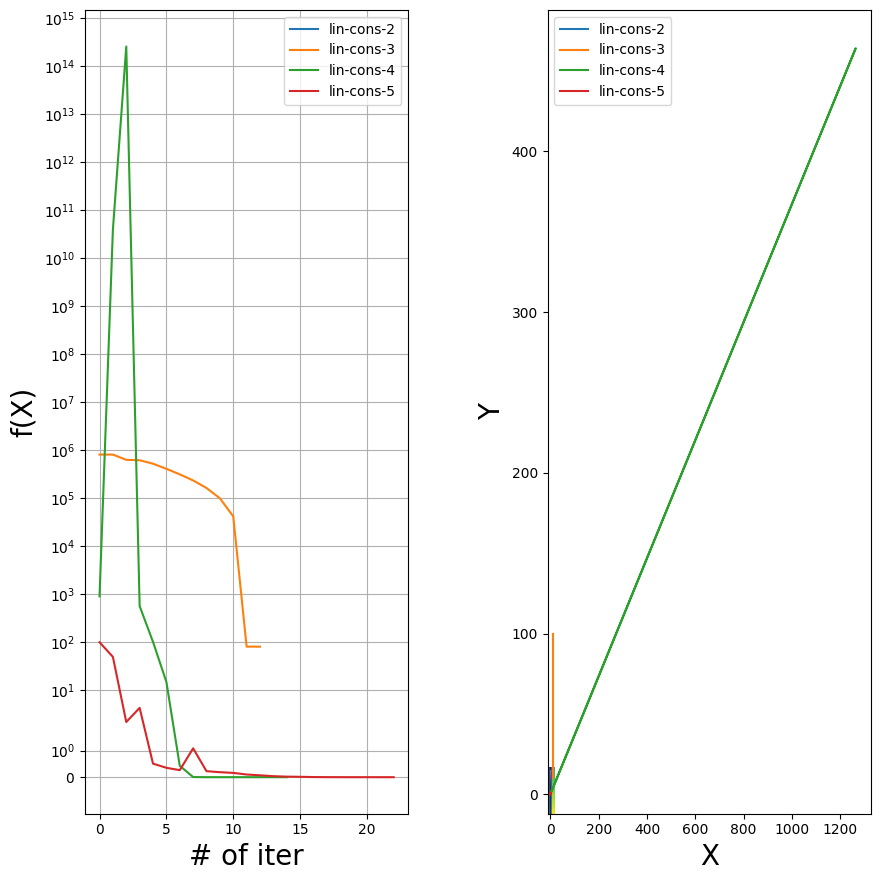

In [32]:
import numpy as np
from scipy.optimize import LinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


lin_cons2 = LinearConstraint([[1, 0], [0, 1,]], [-100, -100], [0, 0])
lin_cons3 = LinearConstraint([[1, 0], [0, 1,]], [10, 10], [np.inf, np.inf])
lin_cons4 = LinearConstraint([[1, 0], [0, 1,]], [1, 1], [np.inf, np.inf])
lin_cons5 = LinearConstraint([[1, 0], [0, 1,]], [-np.inf, -np.inf], [1, 1])


x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons3,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-4": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons4,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "lin-cons-5": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=lin_cons5,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Мы пытаемся прийти к минимуму, но останавливаемся на границе области, в приницпе, этого и следовало ожидать.

### scipy.optimize.NonlinearConstraint

Теперь мы можем перейти к использованию нелинейных ограничений. Теперь мы не ограничены линейными соотношениями, и можем задавать любую функцию от аргументов, и границы на неё. Посмотрим на набор из цилиндров с вырезанным центром:

1. Окружности с центром в $(0, 0)$ и радиусами $0.001 < R^2 < \infty$
2. $0.0001 < R^2 < \infty$
3. $0 < R^2 < 2$

,Метод,Всего точек,Минимум в,Значение в точке минимума,Время работы,Память
0,non-lin-cons-1,74,"[1.0001391504319244, 1.0002655947063772]",3.555673e-08,0.023268,112.791667
1,non-lin-cons-2,33,"[1.0000890989641078, 1.0001839914430302]",1.128591e-08,0.004329,115.755208
2,non-lin-cons-3,21,"[0.9997285059266756, 0.9994444835359618]",8.959014e-08,0.003079,115.812500


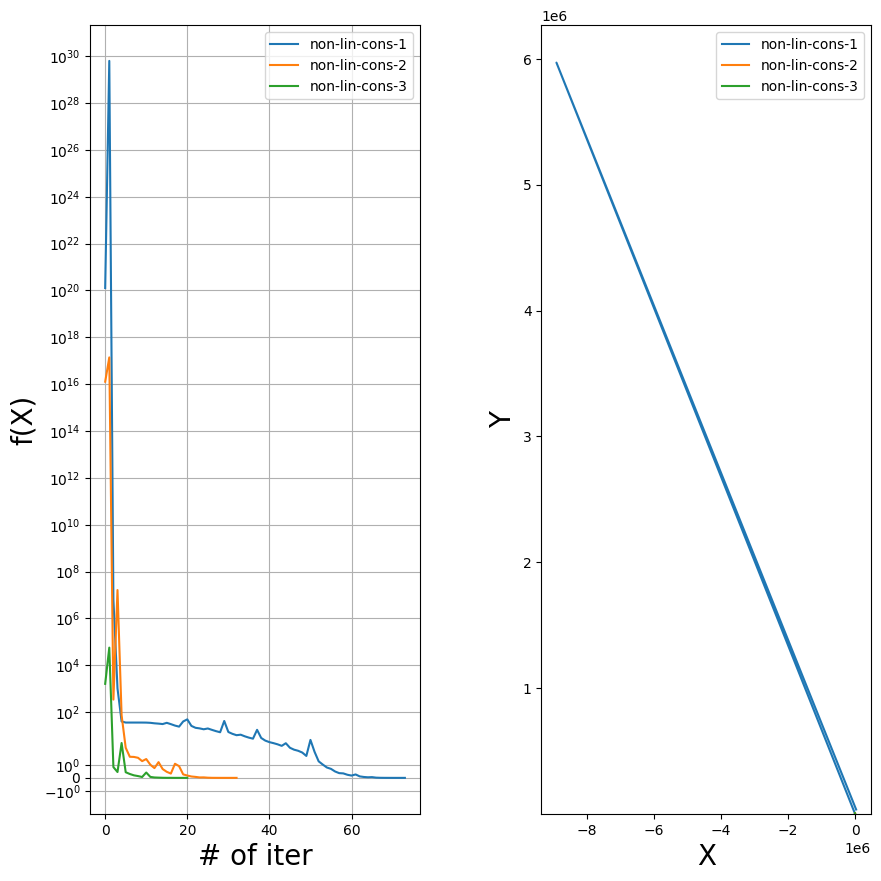

In [35]:
import numpy as np
from scipy.optimize import NonlinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


non_lin1 = NonlinearConstraint(lambda x: x[0] ** 2 + x[1] ** 2, 0.001, np.inf)
non_lin2 = NonlinearConstraint(lambda x: x[0] ** 2 + x[1] ** 2, 0.0001, np.inf)
non_lin3 = NonlinearConstraint(lambda x: x[0] ** 2 + x[1] ** 2, 0, 2)


x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "non-lin-cons-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin1,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "non-lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "non-lin-cons-3": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin3,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Чем больше кусочек ближе к минимуму мы вырезаем, тем больше итераций становится необходимо для схождения к минимуму. Можно попробовать задать более интересные ограничения:

,Метод,Всего точек,Минимум в,Значение в точке минимума,Время работы,Память
0,non-lin-cons-1,23,"[0.9997482217777686, 0.9994858787383292]",7.468816e-08,0.008301,310.171875
1,non-lin-cons-2,23,"[0.9999872360168304, 0.9999743478458853]",1.644656e-10,0.003258,307.671875


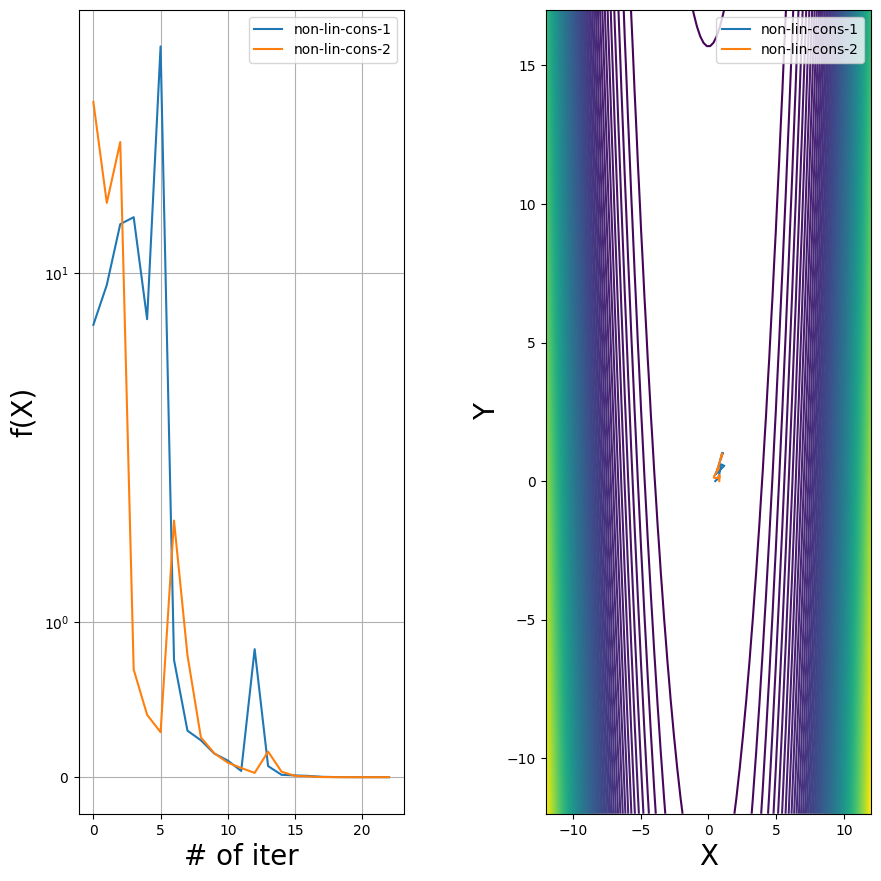

In [44]:
import numpy as np
from scipy.optimize import NonlinearConstraint
from funcs import f_rosenbrock
import descent
import visualization

reload(descent)


non_lin1 = NonlinearConstraint(lambda x: (x[0] - 1) ** 4 - x[1] ** 2 + 1, 0, 10)
non_lin2 = NonlinearConstraint(lambda x: np.sin(x[0]) * np.cos(x[1]),0.1, 0.8)

x0 = np.array([0.0, 0.0])


visualization.visualize_multiple_descent_2args_wh_time(
    {
        "non-lin-cons-1": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin1,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        ),
        "non-lin-cons-2": lambda: descent.scipy_descent(
            f_rosenbrock,
            x0.copy(),
            constraints=non_lin2,
            method="SLSQP",
            tol=1e-6,
            jac="2-point",
        )
    },
    f_rosenbrock,
)


Как можно видеть, ограничения необходимо выбирать осознано, учитвая особенности исследуемых функций. При этом, нелинейные ограничения дают большую свободу в выборе ограничения.

### Вывод

Таким образом, использование ограничений действительно может существенно ускорить схождение к экстремуму. А может и нет. Это зависит от корректности подобранных ограничений к конкретной задаче. 

# Заключение

